# 02807: Computational Tools for Data Science - Project 2

# The AirBnB dataset

<img src="https://www.esquireme.com/public/images/2019/11/03/airbnb-678x381.jpg" alt="airbnb" width="400"/>

[Airbnb](http://airbnb.com) is an online marketplace for arranging or offering lodgings. In the first three exercises you will use Spark to analyze data obtained from the Airbnb website (stricly speaking via data scraped by [insideairbnb](http://insideairbnb.com/get-the-data.html)). The purpose of your analysis is to extract insights about listings as a whole, specifics about London, and sentiment analysis of reviews (word positivity).


## Loading data
The dataset consists of listings (offered lodgings) and reviews (submitted by users). The `.csv`'s you'll work with vary between the first three exercises, but is structured so that the function below will load it into a spark dataframe.

In [ ]:
def load_csv_as_dataframe(path):
    return spark.read.option('header', True) \
                .option('inferSchema', True) \
                .option('multiLine', 'True') \
                .option('escape', '"') \
                .option('mode', 'DROPMALFORMED')\
                .csv(path)

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark import SparkContext, SparkConf

from pandas_profiling import ProfileReport

import pandasql as psql

In [5]:
# Sets memory limit on driver and to use all CPU cores
conf = SparkConf().set('spark.ui.port', '4050') \
        .set('spark.driver.memory', '12g') \
        .setMaster('local[*]')

sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

21/11/29 18:39:11 WARN Utils: Your hostname, Home-PC resolves to a loopback address: 127.0.1.1; using 192.168.0.11 instead (on interface eth0)
21/11/29 18:39:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/11/29 18:39:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [6]:
spark

In [7]:
sc.getConf().getAll()

[('spark.app.id', 'local-1638207553492'),
 ('spark.driver.memory', '12g'),
 ('spark.sql.warehouse.dir',
  'file:/mnt/d/OneDrive%20-%20Danmarks%20Tekniske%20Universitet/DTU/02807%20Computational%20Tools%20for%20Data%20Science/spark-warehouse'),
 ('spark.app.startTime', '1638207552434'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.host', '192.168.0.11'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.ui.port', '4050'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '59566'),
 ('spark.ui.showConsoleProgress', 'true')]

# Exercise 1: Listings and cities (20 pts)

In this exercise you must use Spark to do the data processing. 
* For parts where you present tabular data, this entails calling `toPandas` as the final step of your query. 
* For parts requiring visualisation, the `toPandas` call should be followed only by functions necessary to customize the plotting/layout steps (i.e. no data processing take place after your spark dataframe is materialized).


## Part 1: Preparing the dataframe (5 pts)

Your data source is [this zip archive](https://data-download.compute.dtu.dk/c02807/listings.csv.zip) which you must uncompress and place in the same folder as this notebook. It is loaded in the next cell and named `df_listings`.

After the data is read, you should select the columns necessary for exercise 1, 2 and 3 (by reading ahead or iteratively extend this loading code). Name this dataframe `df_listings_analysis` and make use of caching.

Prices are in local currency, but are nonetheless prefixed with `$` and contains thousands separator commas. You will need to remove these characters and cast the price column to `pyspark.sql.types.DoubleType`. Observe that if this casting is not possible, the result of the cast is `null`.

In [8]:
df_listings = load_csv_as_dataframe('listings.csv')

In [9]:
# Your code goes here
df_listings_analysis = df_listings.select(F.col('id'), F.col('city'), F.col('neighbourhood_cleansed'), F.col('price'), F.col('review_scores_rating'), F.col("property_type")) \
                        .withColumn("price", F.regexp_replace('price', "[^0-9.]+", "")) \
                        .withColumn("price", F.col("price").cast('double')) \
                        .cache()

## Part 2: Listing and neighbourhood counts (5 pts)

Compute and visualise the number of listings and the number of different neighbourhoods per city, restricted to the 15 cities having the most listings. The x-axis should be ordered by number of listings (high to low).

Make sure to use the `neighbourhood_cleansed` column in your computations.


<AxesSubplot:xlabel='city'>

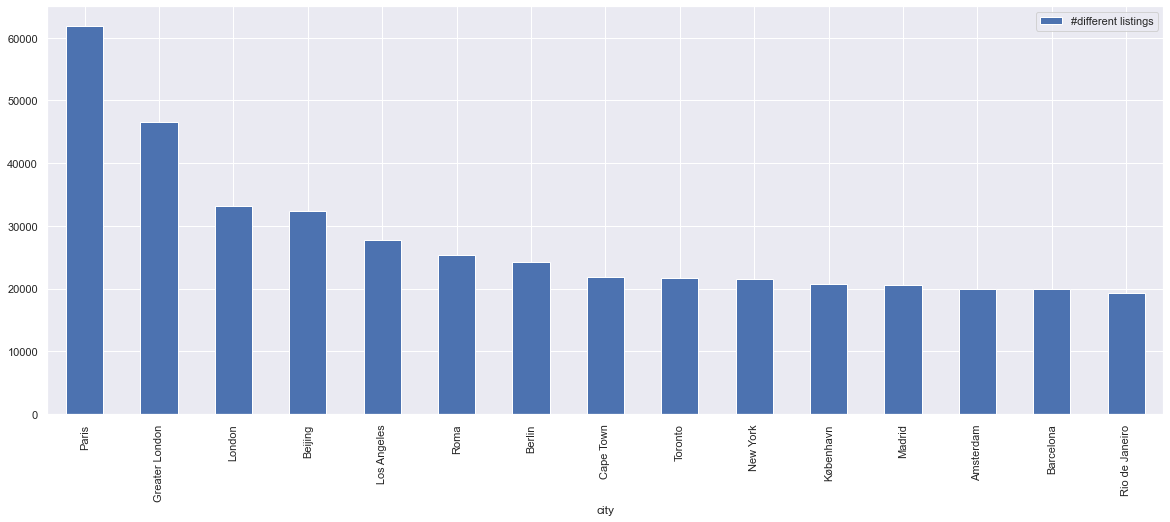

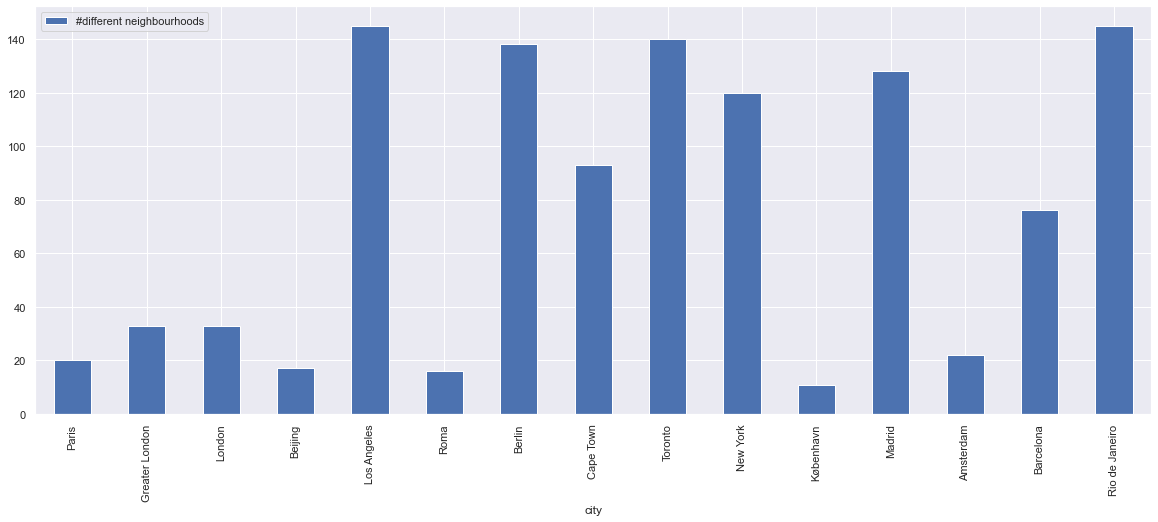

In [10]:
# your code goes here
df_to_plot = df_listings_analysis.groupby(F.col('city')) \
            .agg(F.countDistinct('id').alias('#different listings'),
                 F.countDistinct('neighbourhood_cleansed').alias('#different neighbourhoods')) \
            .sort(F.col('#different listings'), ascending=False) \
            .limit(15) \
            .toPandas()
df_to_plot.plot(x="city", y="#different listings", kind="bar", figsize=(20,7.5))
df_to_plot.plot(x="city", y="#different neighbourhoods", kind="bar", figsize=(20,7.5))

## Part 3: Price averages (5 pts)

Compute and visualise the average price of listings per city, restricted to the 15 cities having the most listings.

<AxesSubplot:xlabel='city'>

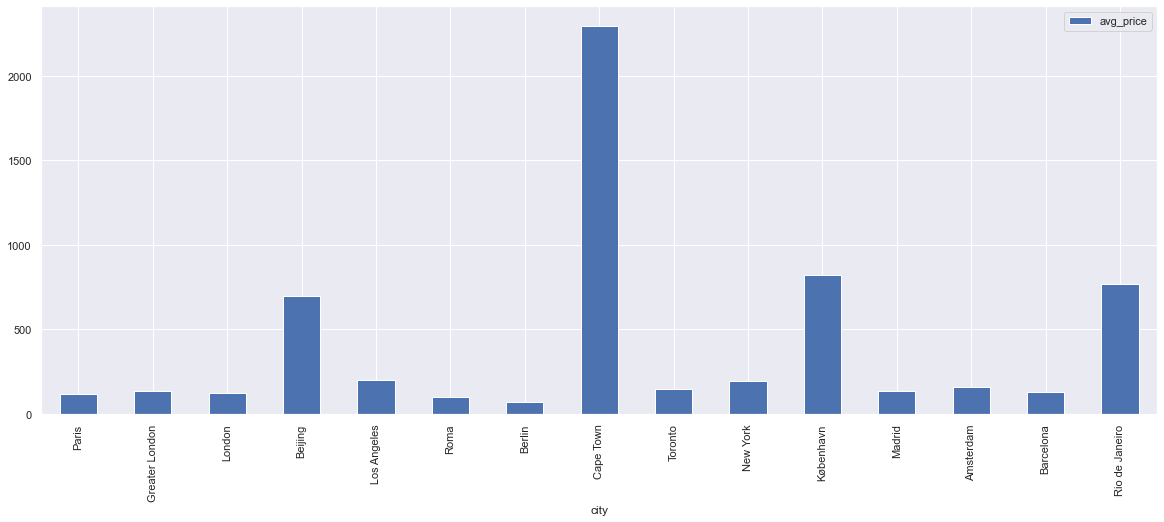

In [11]:
# your code goes here
df_listings_analysis.groupby(F.col('city')) \
                    .agg(F.countDistinct('id').alias('#different listings'),
                         F.avg('price').alias('avg_price')) \
                    .sort(F.col('#different listings'), ascending=False) \
                    .limit(15) \
                    .toPandas() \
                    .plot(x="city", y="avg_price", kind="bar", figsize=(20,7.5))

## Part 4: Value for money (5 pts)

The value of a listing is its rating divided by its price. The value of a city is the average value of its listings. 

Prices are only comparable when the local currency is the same. We'll therefore consider a subset of Euro-zone cities as defined in `eurozone_cities`.

Compute and visualise the value per city, restricted to the Euro-zone cities.

In [12]:
eurozone_cities = [
    'Paris', 'Roma', 'Berlin', 'Madrid', 'Amsterdam', 'Barcelona', 'Milano', 'Lisboa',
    'München', 'Wien', 'Lyon', 'Firenze', 'Porto', 'Napoli', 'Bordeaux', 'Venezia',
    'Málaga', 'Sevilla', 'València'
]

<AxesSubplot:xlabel='city'>

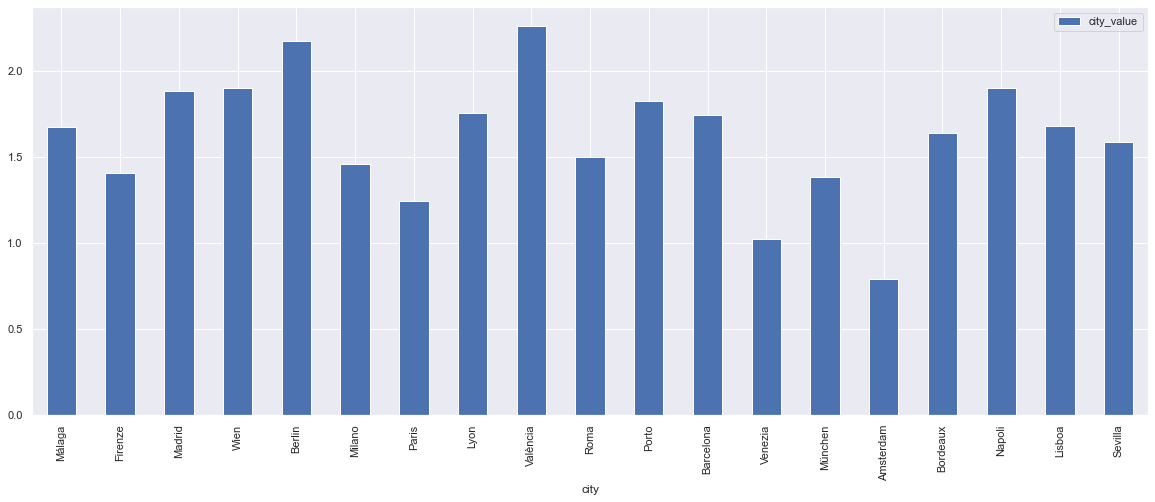

In [13]:
# your code goes here
df_listings_analysis.filter(F.col('city').isin(eurozone_cities)) \
                    .withColumn("listing_value", F.expr("review_scores_rating / price")) \
                    .groupby(F.col('city')) \
                    .agg(F.avg('listing_value').alias('city_value')) \
                    .toPandas() \
                    .plot(x="city", y="city_value", kind="bar", figsize=(20,7.5))

# Exercise 2: The case of London (30 pts)

In this exercise you must use Spark to do the data processing. 
* For parts where you present tabular data, this entails calling `toPandas` as the final step of your query. 
* For parts requiring visualisation, the `toPandas` call should be followed only by functions necessary to customize the plotting/layout steps (i.e. no data processing take place after your spark dataframe is materialized). 
* You may need multiple queries to solve the individual parts.

Your dataframe is a subset of `df_listings_analysis` and should be named `df_listings_london`.

In [14]:
# your code goes here
df_listings_london = df_listings_analysis.filter(F.col("city") == "London")

## Part 1: Price distribution (5 pts)

Compute and visualise the distribution of prices, for all prices up to and including the 95-percentile. Additionally, compute and visualise the distribution of prices, for all prices above the 95-percentile.

<AxesSubplot:ylabel='Frequency'>

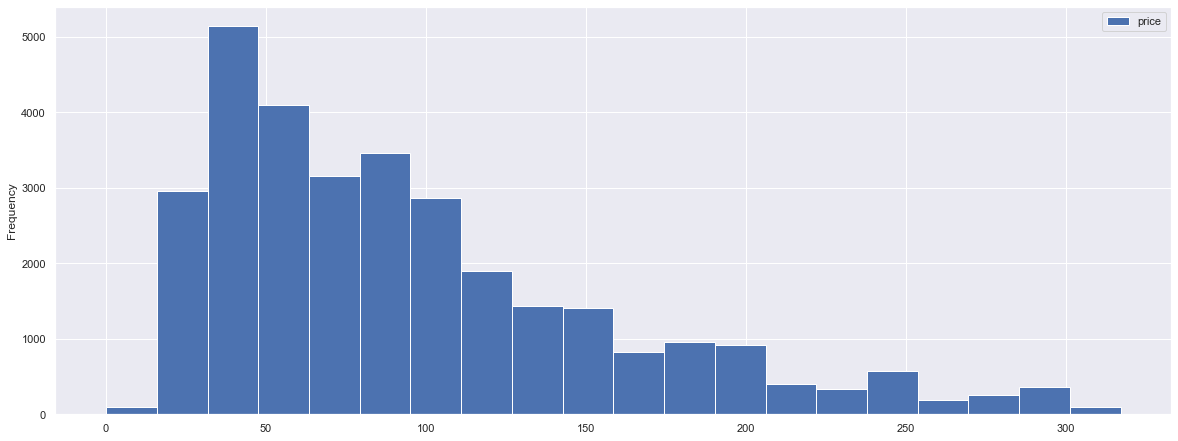

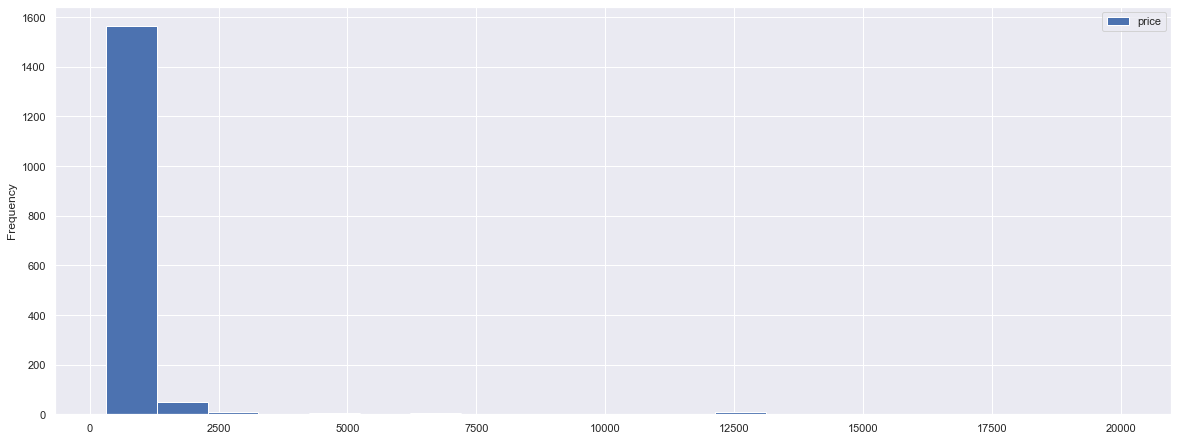

In [15]:
# your code goes here
percentile_95 = df_listings_london.selectExpr("percentile_approx(price, 0.95)").toPandas().values[0][0]
df_listings_london.filter(F.col("price") <= percentile_95).toPandas().plot(bins=20, kind="hist", figsize=(20,7.5))
df_listings_london.filter(F.col("price") > percentile_95).toPandas().plot(bins=20, kind="hist", figsize=(20,7.5))

## Part 2: Prices by type of property (5 pts)

Compute and visualise the average price and average rating per type of property, for property types with 75 or more listings. 

Your visualisation should be a single bar chart with two y-axes and two bars per property type. The x-axis should be ordered by average rating.

<AxesSubplot:xlabel='property_type'>

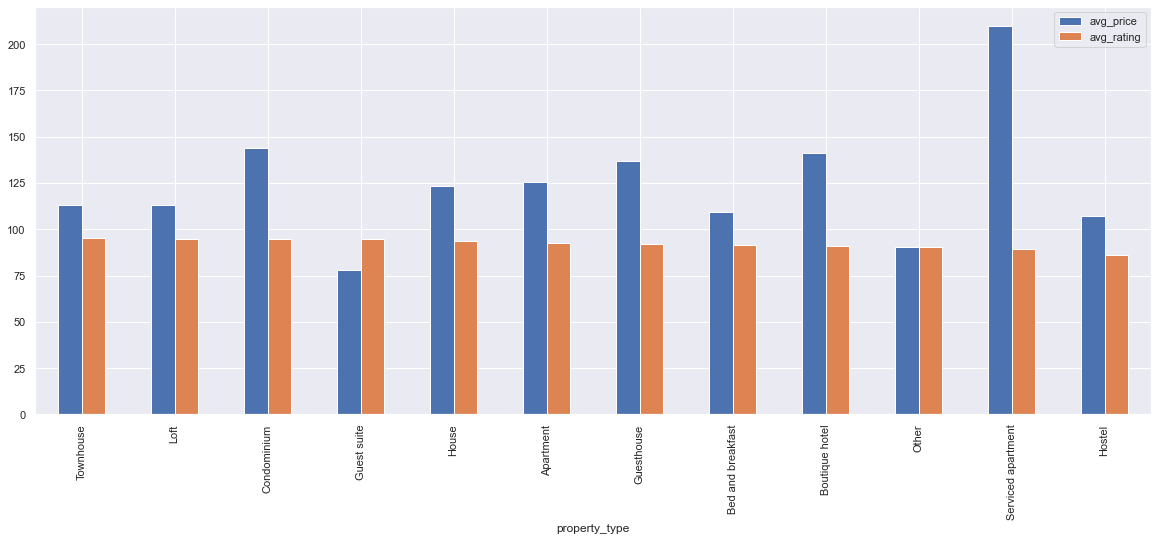

In [16]:
# your code goes here
df_listings_london.groupby(F.col('property_type')) \
                    .agg(F.countDistinct('id').alias('#different listings'),
                         F.avg('price').alias('avg_price'),
                         F.avg('review_scores_rating').alias('avg_rating')) \
                    .filter(F.col('#different listings') >= 75) \
                    .sort(F.col('avg_rating'), ascending=False) \
                    .toPandas() \
                    .plot(x="property_type", y=["avg_price", "avg_rating"], kind="bar", figsize=(20,7.5))

## Part 3: Best offering in the neighbourhood (10 pts)

The value of a listing is its rating divided by its price. Compute and display a dataframe (with the columns you selected in Exercise 1 and those computed in this part) with the 3 highest valued listings in each neighbourhood, and having a value above 5. Make sure to use the `neighbourhood_cleansed` column in your computations.

Computing ranks based on value can be achieved using `pyspark.sql.window.Window`. This may produce equal ranks (i.e. when the value of two listings are the same).

Remember to use `pd.set_option('display.max_rows', <n>)` with appropriate `<n>` so all rows are displayed.

In [17]:
# your code goes here
windowSpec = pyspark.sql.window.Window.partitionBy("neighbourhood_cleansed").orderBy(F.col("listing_value").desc())
ranked_listings_by_neighbourhood = df_listings_london.withColumn("listing_value", F.expr("review_scores_rating / price")) \
                            .withColumn("value_rank_in_neighbourhood", F.dense_rank().over(windowSpec)) \
                            .filter((F.col("value_rank_in_neighbourhood") < 4) & (F.col("listing_value") > 5)) \
                            .toPandas()
pd.set_option('display.max_rows', len(ranked_listings_by_neighbourhood))
ranked_listings_by_neighbourhood

,id,city,neighbourhood_cleansed,price,review_scores_rating,property_type,listing_value,value_rank_in_neighbourhood
0,12458875,London,Barnet,19.0,98,House,5.157895,1
1,16906771,London,Brent,14.0,91,House,6.500000,1
2,5001727,London,Brent,15.0,94,Apartment,6.266667,2
3,12164995,London,Brent,13.0,81,Hostel,6.230769,3
4,20029439,London,Bromley,10.0,100,House,10.000000,1
5,24979813,London,Camden,16.0,90,Hostel,5.625000,1
6,13105708,London,Camden,15.0,80,Apartment,5.333333,2
7,24978338,London,Camden,17.0,90,Hostel,5.294118,3
8,7208317,London,Croydon,18.0,92,House,5.111111,1
9,8420459,London,Croydon,19.0,97,Apartment,5.105263,2


## Part 4: Activity by month (5 pts)

Activity is given by the number of reviews received in a given time period. Compute and visualise the activity based on month, that is, the total number of reviews given in January, February, etc..

Your additional data source is [this zip archive](https://data-download.compute.dtu.dk/c02807/reviews_london.csv.zip) which you must uncompress and place in the same folder as this notebook. It is loaded in the next cell and named `df_reviews_london`.

In [18]:
df_reviews_london = load_csv_as_dataframe('reviews_london.csv')

<AxesSubplot:xlabel='month'>

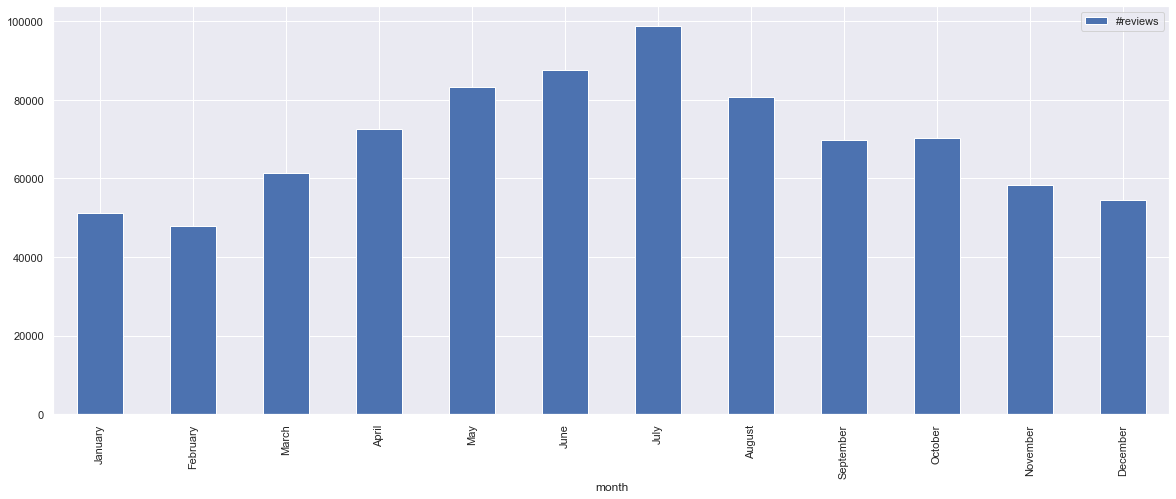

In [19]:
# your code goes here
months_dict = {"1": "January", "2": "February", "3": "March", "4": "April", "5": "May", "6": "June", "7": "July", "8": "August", "9": "September", "10": "October", "11": "November", "12": "December"}

df_reviews_london.withColumn("month", pyspark.sql.functions.month("date")) \
                    .groupby(F.col('month')) \
                    .agg(F.countDistinct('id').alias('#reviews')) \
                    .sort(F.col('month')) \
                    .withColumn("month", F.col("month").cast('string')) \
                    .replace(months_dict, subset=['month']) \
                    .toPandas() \
                    .plot(x="month", y="#reviews", kind="bar", figsize=(20,7.5))

## Part 5: Reviews per listing (5 pts)

Each London listing has received 0 or more reviews. 

Display a dataframe showing 1) The number of listings, 2) The average number of reviews a listing receives, 3) The standard deviation of the reviews per listing distribution, 4) The minimum number of reviews any listing has received, and 5) The maximum number of reviews any listing has received.

In [20]:
# your code goes here
merged = df_listings_london.join(df_reviews_london.groupby(F.col('listing_id')).agg(F.countDistinct('id').alias('#reviews')), F.col('id') == F.col('listing_id'), 'outer') \
                            .na.fill(value=0, subset=["#reviews"])

merged.agg(F.countDistinct('id').alias('#listings'),
             F.avg('#reviews').alias('avg_#reviews'),
             F.stddev('#reviews').alias('std_#reviews'),
             F.min('#reviews').alias('min_#reviews'),
             F.max('#reviews').alias('max_#reviews')
            ) \
        .toPandas()

,#listings,avg_#reviews,std_#reviews,min_#reviews,max_#reviews
0,33100,25.26864,46.943509,0,690


# Exercise 3: Word sentiment (45 pts)

In this exercise you must use Spark to do the data processing. For parts where you present tabular data, this entails calling `toPandas` as the final step of your query. You may need multiple queries to solve the individual parts.

The goal here is to determine what sentiment (positive or negative) words in reviews have. Roughly speaking, we want each word to be assigned a score based on the rating of the reviews in which the word occurs in the review comment. We'd expect words such as "clean", "comfortable", "superhost" to receive high scores, while words such as "unpleasant", "dirty", "disgusting" would receive low scores.

As individual reviews do not have a rating, we'll consider the rating of individual reviews to be the rating of its related listing (i.e. assuming each review gave the average rating (`review_scores_rating`) of the listing). 

The score of a word is given by the mean review rating over the reviews in which that word occurs in the comment. We require words to appear in at least 0.5% (1 in 200) listings, and to be at least 4 characters, for it to have a defined score.

Formally, when a word $w$ occurs in at least $0.5\%$ of listings and $|w| > 3$, its score is

$
\begin{align*}
score(w) = \frac{1}{|C_w|}\sum_{comment \in C_w} \text{review_rating}(comment)
\end{align*}
$
, where 
* $C_w = \{comment \mid w \text{ occurs in } \text{clean_text}(comment)\}$, the set (so no duplicates) of comments in which $w$ occurs, and
* $\text{clean_text}(comment)$ is the result of your `clean_text` function defined below, and
* $\text{review_rating}(comment)$ is the `review_scores_rating` of the listing which this $comment$ is related to.


## Part 1: Toy data (15 pts)

To get started we'll consider a toy example where the input is `df_sentiment_listings_toy` and `df_sentiment_reviews_toy` defined in the next code cell. You should provide an implementation of `calculate_word_scores_toy` in the subsequent code cell. Your implementation should result in a query that when given the toy example dataframes as input and is materialized with `toPandas()` produces this table:

|    | word   |   word_score |   listing_occurences |   word_occurences |   comment_occurences |
|---:|:-------|-------------:|---------------------:|------------------:|---------------------:|
|  0 | aaaa   |      7       |                    3 |                 5 |                    5 |
|  1 | bbbb   |      6.66667 |                    2 |                 3 |                    3 |
|  2 | eeee   |      0       |                    1 |                 1 |                    1 |
|  3 | dddd   |      5       |                    1 |                 1 |                    1 |
|  4 | cccc   |      5       |                    2 |                 2 |                    2 |'

Observe that `word_occurences` and `comment_occurences` are the same as words occuring multiple times in a comment are counted once, and that `clean_text` is used to ignore casing and discard non-words. Additionally, any word occuring at least once will occur in more than 1 out of 200 listings on this toy data.

In [8]:
from pyspark.sql.types import StructType, StructField, StringType

schema_listings = StructType([
    StructField('id', StringType(), True),
    StructField('review_scores_rating', StringType(), True),
])
data_listings = [
    {'id': '0', 'review_scores_rating': '10'},
    {'id': '1', 'review_scores_rating': '5'},
    {'id': '2', 'review_scores_rating': '0'},
]
df_sentiment_listings_toy = spark.createDataFrame(data_listings, schema_listings)

schema_reviews = StructType([
    StructField('listing_id', StringType(), True),
    StructField('id', StringType(), True),
    StructField('comments', StringType(), True),
])
data_reviews = [
    {'listing_id': '0', 'id': '100', 'comments': 'aaaa bbbb          cccc'},
    {'listing_id': '0', 'id': '101', 'comments': 'aaaa bbbb '},
    {'listing_id': '0', 'id': '102', 'comments': 'aaaa aAAa          aaaa'},
    {'listing_id': '1', 'id': '103', 'comments': 'Aaaa bbb ccc'},
    {'listing_id': '1', 'id': '104', 'comments': 'dddd %ˆ&*'},
    {'listing_id': '2', 'id': '105', 'comments': 'AaaA'},
    {'listing_id': '2', 'id': '106', 'comments': 'bbbb ccc e&eˆˆee'},
    {'listing_id': '2', 'id': '107', 'comments': 'cccc cccc'},
]

df_sentiment_reviews_toy = \
    spark.createDataFrame(data_reviews, schema_reviews) \
        .select(F.col('listing_id'), F.col('id').alias('comment_id'), F.col('comments'))


In [9]:
# your code goes here
def clean_text(col):
    """
        Cleans the text (comment) associated with col. The
        cleaning should:
            1) Lower case the text
            2) Turn multiple whitespaces into single whitespaces
            3) Remove anything but letters, digits and whitespaces
        
        :col: A Spark Column object containing text data
        :returns: A Spark Column object.
    """
    return F.regexp_replace(F.lower(F.regexp_replace(col,'\s+',' ')),'[^a-z0-9\s]','')

def calculate_word_scores_toy(df_list, df_rev):
    """
        Calculates the word score over listings in df_list and
        reviews in df_rev. The table produced should have the 
        same columns as specified in part 1.
        
        :returns: A pandas DataFrame
    """

    df = df_rev.withColumn('comments',clean_text(F.col('comments'))) \
                            .select(F.col('listing_id'),
                                    F.col('comment_id'),
                                    F.explode(F.split(F.col('comments'), ' ')).alias('word')) \
                            .filter(F.length(F.col('word'))>3)
    
    df_occurences = df.groupby(F.col('word')) \
                        .agg(F.countDistinct('listing_id').alias('listing_occurences'),
                             F.countDistinct('comment_id').alias('word_occurences'))
    
    df_score = df.groupby(F.col('listing_id'),
                          F.col('word')) \
                    .agg(F.countDistinct(F.col('comment_id')).alias('word_comment_count')) \
                    .join(df_list,
                          F.col('listing_id')==F.col('id')) \
                    .groupby(F.col('word')) \
                    .agg(F.sum(F.col('word_comment_count')*F.col('review_scores_rating')).alias('score'))
    
    return df_occurences.join(df_score, on=['word']) \
                        .withColumn('word_score',F.col('score')/F.col('word_occurences')) \
                        .drop(F.col('score')) \
                        .withColumn('comment_occurences',F.col('word_occurences'))\
                        .select(F.col('word'),
                                F.col('word_score'),
                                F.col('listing_occurences'),
                                F.col('word_occurences'),
                                F.col('comment_occurences')) \
                        .toPandas()


calculate_word_scores_toy(df_sentiment_listings_toy, df_sentiment_reviews_toy)

,word,word_score,listing_occurences,word_occurences,comment_occurences
0,aaaa,7.000000,3,5,5
1,bbbb,6.666667,2,3,3
2,eeee,0.000000,1,1,1
3,dddd,5.000000,1,1,1
4,cccc,5.000000,2,2,2


## Part 2: London comments (15 pts)

In this part we'll calculate word scores for the comments related to London listings only. You should implement `count_relevant_listings` and `calculate_word_scores` (it will be an extension of your function from part 1) below. See the mathematical definition and docstrings for intended behaviour.

The function `calculate_word_scores` should return the top 10 and bottom 10 words by score. You should **not** use caching in your function.

Make sure your satisfy all conditions for a word to be scored (e.g. correctly calculating how many total listings scores are computed over). You should also consider whether your query is optimally structured in terms of computation time. Moreover, `pd.set_option('display.max_rows', <n>)` should be set with sufficiently high `n` to show all words.

In [24]:
# your code goes here
def count_relevant_listings(df_list, df_rev):
    """
        Calculates the number of listings in df_list that has a 
        review in df_rev. A listing that is reviewed more than once
        should only count as one.
        
        :returns: An integer
    """
    return df_rev.select(F.col('listing_id')).intersect(df_list.select(F.col('id'))).count()

def calculate_word_scores(df_list, df_rev, listings_count):
    """
        Calculates the word score over listings in df_list and
        reviews in df_rev. The value of listings_count should 
        be used to filter out words not occuring frequently enough
        in comments. The table produced should have the same columns
        as in part 1 of this exercise.
        
        :returns: A pandas DataFrame containing the top 10 and 
        bottom 10 words based on their word score, sorted by word_score.
    """
    
    df_rev_list = df_rev.select(F.col('listing_id'),
                                F.col('comments'),
                                F.col('id').alias('comment_id')) \
                        .join(df_list.select(F.col('id'),F.col('review_scores_rating')),
                              on=F.col('listing_id')==F.col('id'), how='inner') \
                        .drop(F.col('id'))

    df = df_rev_list.withColumn('comments',clean_text(F.col('comments'))) \
                    .select(F.col('listing_id'),
                            F.col('comment_id'),
                            F.col('review_scores_rating'),
                            F.explode(F.split(F.col('comments'), ' ')).alias('word')) \
                    .filter(F.length(F.col('word'))>3)

    df_occurences = df.groupby(F.col('word')) \
                        .agg(F.countDistinct('listing_id').alias('listing_occurences'),
                             F.countDistinct('comment_id').alias('comment_occurences')) \
                        .filter(F.col('listing_occurences')/listings_count > 0.005)

    df_score = df.groupby(F.col('listing_id'),
                          F.col('word'),
                          F.col('review_scores_rating')) \
                    .agg(F.countDistinct(F.col('comment_id')).alias('word_comment_count')) \
                    .groupby(F.col('word')) \
                    .agg(F.sum(F.col('word_comment_count')*F.col('review_scores_rating')).alias('word_score'))

    df_final = df_occurences.join(df_score, on=['word'], how = 'inner') \
                            .withColumn('word_score',F.col('word_score')/F.col('comment_occurences')) \
                            .withColumn('word_occurences',F.col('comment_occurences'))\
                            .select(F.col('word'),
                                    F.col('word_score'),
                                    F.col('listing_occurences'),
                                    F.col('word_occurences'),
                                    F.col('comment_occurences')) \
                            .sort(F.col('word_score'),ascending=False)
    
    df_pandas = df_final.toPandas()
    return pd.concat([df_pandas.head(10), df_pandas.tail(10)])

In [25]:
# should not be modified
from IPython.display import display

relevant_listings_count_london = count_relevant_listings(df_listings_london, df_reviews_london)
word_scores_london_timing = %timeit -o -n1 -r1 display( \
    calculate_word_scores(df_listings_london, \
                          df_reviews_london, \
                          relevant_listings_count_london) \
)

word_scores_london_timing.best

,word,word_score,listing_occurences,word_occurences,comment_occurences
0,granola,97.553279,153,244,244
1,homemade,97.267500,474,1200,1200
2,superhost,97.057178,687,822,822
3,yogurt,97.054264,245,387,387
4,yoghurt,97.037037,146,216,216
5,baked,96.942593,296,540,540
6,muesli,96.897727,180,264,264
7,lovelier,96.863636,130,132,132
8,divine,96.800000,164,180,180
9,jane,96.747204,131,1788,1788


1min 40s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


100.02977509999994

## Part 3: Scalability (10 pts)

The listings from London make up a little less than 2% of the entire set of listings. In this part we're interested in how the amount of input data impacts computation time, that is, how `calculate_word_scores` scales as data increases. To this end, we've made multiple samples of the dataset of varying sizes.

The experiment reuses `count_relevant_listings` and `calculate_word_scores` that you implemented in part 2. Code needed for this part is provided to you. 

Your task is to obtain the data sources, run the code cells below, and explain the results you get. Specifically, you must explain any non-linear relationship between data size and computation time, using the markdown cell at the end of this part. In finding explanations, using the Spark UI to investigate the anatomy of your queries may prove valuable. Once you've found an explanation, state a potential solution to remedy the issue. Lastly, include a paragraph stating the specifications of your computer hardware (memory, CPU cores and clock speed, solid state disk or not) on which the experiment has been run.

*Implementation note* Make sure you've properly configured `spark.driver.memory` (it requires a kernel restart to update the value). It may be that your query fails on the larger samples due to running out of compute resources. This is likely caused by a suboptimal `calculate_word_scores`, but can be from reaching the limits of your hardware. If you think the latter is the case, argue for this perspective in the markdown cell.

Your data sources are (uncompress and place in the same directory as this notebook):
* 0.25%: [listings](https://data-download.compute.dtu.dk/c02807/listings_0-dot-25percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_0-dot-25percent.csv.zip)
* 0.5%: [listings](https://data-download.compute.dtu.dk/c02807/listings_0-dot-5percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_0-dot-5percent.csv.zip)
* 1%: [listings](https://data-download.compute.dtu.dk/c02807/listings_1-dot-0percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_1-dot-0percent.csv.zip)
* 2%: [listings](https://data-download.compute.dtu.dk/c02807/listings_2-dot-0percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_2-dot-0percent.csv.zip)
* 4%: [listings](https://data-download.compute.dtu.dk/c02807/listings_4-dot-0percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_4-dot-0percent.csv.zip)
* 8%: [listings](https://data-download.compute.dtu.dk/c02807/listings_8-dot-0percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_8-dot-0percent.csv.zip)
* 12.5%: [listings](https://data-download.compute.dtu.dk/c02807/listings_12-dot-5percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_12-dot-5percent.csv.zip)
* 16%: [listings](https://data-download.compute.dtu.dk/c02807/listings_16-dot-0percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_16-dot-0percent.csv.zip)
* 25%: [listings](https://data-download.compute.dtu.dk/c02807/listings_25-dot-0percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_25-dot-0percent.csv.zip)
* 50%: [listings](https://data-download.compute.dtu.dk/c02807/listings_50-dot-0percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_50-dot-0percent.csv.zip)
* 75%: [listings](https://data-download.compute.dtu.dk/c02807/listings_75-dot-0percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_75-dot-0percent.csv.zip)
* 100%: [listings](https://data-download.compute.dtu.dk/c02807/listings_100-dot-0percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_100-dot-0percent.csv.zip)

In [26]:
import time
def calculate_word_scores_timed(percent_str):
    """
        Calculates word scores over a sampled dataset indicated
        by percent_str.
        
        :returns: A dictionary with benchmarking information and
        the calculated values.
    """
    df_listings = load_csv_as_dataframe(f'listings_{percent_str}percent.csv')
    df_reviews = load_csv_as_dataframe(f'reviews_{percent_str}percent.csv')
    
    listings_count = count_relevant_listings(df_listings, df_reviews)

    start = time.time()
    df_word_scores = calculate_word_scores(df_listings, df_reviews, listings_count)
    end = time.time()
    return {
        'percentage': float(percent_str.replace('-dot-', '.')), 
        'time_spent': f"{end - start:.2f}", 
        'relevant_listings': listings_count, 
        'df': df_word_scores
    }

In [27]:
data_percentages = [
    '0-dot-25', '0-dot-5', '1-dot-0', '2-dot-0', '4-dot-0', '8-dot-0',
    '12-dot-5', '16-dot-0', '25-dot-0'
]
#score_data = {
#    percentage_str: calculate_word_scores_timed(percentage_str) for percentage_str in data_percentages
#}

In [28]:
#score_data['50-dot-0'] = calculate_word_scores_timed('50-dot-0')

In [29]:
#score_data['75-dot-0'] = calculate_word_scores_timed('75-dot-0')

In [30]:
#score_data['100-dot-0'] = calculate_word_scores_timed('100-dot-0')

In [31]:
# df_scores_scaling = pd.DataFrame(score_data).T.convert_dtypes()
# df_scores_scaling.time_spent = df_scores_scaling.time_spent.astype(float)
df_scores_scaling = pd.read_pickle("df_scores_scaling.pkl")

# Access to word scores of 2 percent data: df_scores_scaling.loc['2-dot-0'].df
df_scores_scaling

,percentage,time_spent,relevant_listings,df
0-dot-25,0.25,133.77,2529,word word_score listing_occuren...
0-dot-5,0.5,142.51,5040,word word_score listing_occu...
1-dot-0,1.0,187.86,10143,word word_score listing_occuren...
2-dot-0,2.0,247.10,20575,word word_score listing_occuren...
4-dot-0,4.0,432.11,40919,word word_score listing_occu...
8-dot-0,8.0,800.59,81756,word word_score listing_occu...
12-dot-5,12.5,752.90,128202,word word_score listing_occu...
16-dot-0,16.0,908.95,163627,word word_score listing_occu...
25-dot-0,25.0,1320.33,256183,word word_score listing_occu...
50-dot-0,50.0,2975.92,511667,word word_score listing_occu...


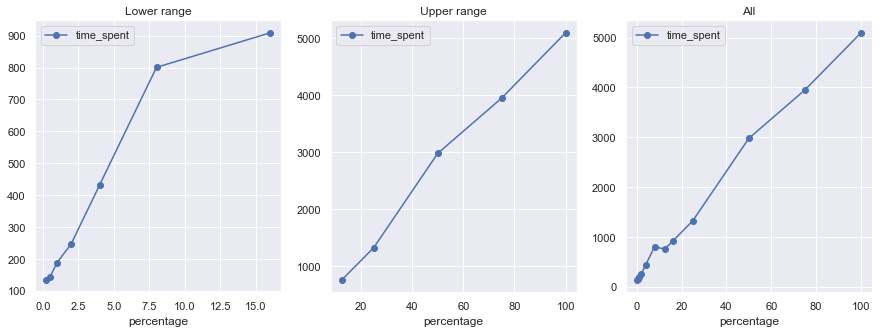

In [32]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

lower_range = ['0-dot-25', '0-dot-5', '1-dot-0', '2-dot-0', '4-dot-0', '8-dot-0', '16-dot-0']
df_scores_scaling[df_scores_scaling.index.isin(lower_range)] \
    .plot.line(x='percentage', y='time_spent', ax=axes[0], style='-o', title='Lower range')
df_scores_scaling[~df_scores_scaling.index.isin(lower_range)] \
    .plot.line(x='percentage', y='time_spent', ax=axes[1], style='-o', title='Upper range')
_ = df_scores_scaling \
    .plot.line(x='percentage', y='time_spent', ax=axes[2], style='-o', title='All')

*Your explanation to the questions outlined at the start of this part goes here. Make sure you've addressed all questions asked.*

On the full graph we see the datapoints divide into two groups the lower range 0.25%-8% and upper range 12.5%-100%. Time spend increase linearly with data size for both groups, but with different slopes, the lower range has a stepper slope than the upper range. We also see a drop in time spend between 8% and 12.5%. Comparing the jobs of the lower range with jobs in the upper range in the spark UI we see that the review csv (the bigger of the two csv files needed) is loaded twice for the lower range jobs but only once for the upper range jobs. In the upper range it reuses the first scan of the file, and in the lower range it scans the file twice. This can also be seen in the physical plan where for the upper range the plan includes a `reusedExchange` instead of a `FileScan csv`.
A potential solution to this could be to somehow force spark to recognise that it is scaning the csv file twice and instead reuse the first file scan as it does in the plan for the upper range. This optimization seem to happen when the filesize exceeds 1GB so if it is possible to lower that requirement, the lower and upper range would have the same slope, and be slightly faster as the listings csv is being scanned twices for all jobs.


Hardware:
- 16Gb ram 2133MHz
- CPU i5-6600K 3.5Ghz 4 cores
- SSD

## Part 4: Robustness (5 pts)

In this part we'll explore robustness of our word scores, using the values we computed in part 3. We'll do so by comparing top/bottom words for three different samples of the dataset. Specifically, the scores from your maximum (e.g. 100%) computed sample are to be compared with the 12.5% and 2.0% scores.

Compute and display a dataframe that accounts for any word found in either of the three samples' top/bottom words, and additionally shows the related `word_score` and `word_occurences` values.

Note that `df_scores_scaling.loc['100-dot-0'].df` provides the word scores dataframe of the 100% sample (similarly for the other two). For this part you should rely on pandas functionality only.  Moreover, `pd.set_option('display.max_rows', <n>)` should be set with sufficiently high `n` to show all rows.

In [33]:
# your code goes here
# Extract the dataframes with the columns needed (to make it more convenient)
df_100 = df_scores_scaling.loc['100-dot-0'].df[['word','word_score','word_occurences']]
df_125 = df_scores_scaling.loc['12-dot-5'].df[['word','word_score','word_occurences']]
df_2 = df_scores_scaling.loc['2-dot-0'].df[['word','word_score','word_occurences']]

# Merge the three dataframes on word using outer merge
df_full = pd.merge(pd.merge(df_100,df_125,on='word',how='outer'),df_2,on='word',how='outer') \
            .rename(columns={'word_score_x':'word_score_100',
                             'word_score_y':'word_score_12.5',
                             'word_score':'word_score_2',
                             'word_occurences_x':'word_occurences_100',
                             'word_occurences_y':'word_occurences_12.5',
                             'word_occurences':'word_occurences_2'})


display(df_full)

,word,word_score_100,word_occurences_100,word_score_12.5,word_occurences_12.5,word_score_2,word_occurences_2
0,nashville,97.516548,115904.0,97.658064,15383.0,97.457931,2175.0
1,thoughtfulness,97.467744,10029.0,97.497272,1283.0,NaN,NaN
2,muffins,97.431204,18395.0,97.444230,2071.0,NaN,NaN
3,baked,97.367440,22488.0,NaN,NaN,NaN,NaN
4,meticulously,97.366348,6704.0,97.462253,861.0,NaN,NaN
5,homemade,97.358921,43589.0,97.343706,5688.0,97.548554,968.0
6,immaculate,97.334977,95723.0,97.328491,12116.0,NaN,NaN
7,touches,97.320999,400755.0,97.331379,50477.0,NaN,NaN
8,goodies,97.320273,28713.0,NaN,NaN,97.527434,565.0
9,magazine,97.317357,17797.0,NaN,NaN,97.563525,488.0


# Exercise 4: Transactions analysis (55 pts)

In this exercise the goal is to analyse historical business transactions (sales of parts to other companies), and derive insights about both products and customers.

The company X produces and globally sells gadget parts to a number of other companies. You requested the sales department of X to provide you with access to the customer and sales transactions database. To your horror, you've found no such database exists, but the data is instead manually maintained in a spreadsheet (error-prone solution). Intrepid as you are, you've accepted to receive the spreadsheet data as a `.csv`, realizing already data cleaning will be necessary.

Your first step (parts 1 and 2) is to clean the data after which you will derive insights about X's business operations (parts 3 and 4).

The input data is available here: [transactions.csv](http://courses.compute.dtu.dk/02807/2021/projects/project2/transactions.csv)

**Using SQL**

In this final exercise you must write SQL to do the data processing in parts 3 and 4. This entails using `psql.sqldf` to execute your queries (up against `df_transactions_cleaned`) which will return a pandas dataframe. Each question should be answered with a *single* query. For visualisation the `psql.sqldf` call should be followed only by functions necessary to customize the plotting/layout steps or reshape the dataframe (i.e. no data processing take place after your SQL statement is materialized as a pandas dataframe).

In part 1 and 2 of this exercise, you should make use of pandas functionality.



## Part 1: Data cleaning (15 pts)

For each column in the dataframe, investigate and **correct** problematic aspects such as,
* Missing values: Insert meaningful values (data imputation). Detectable as `np.nan`'s. A typical value for imputation is the *mode* (most frequent value) of the distribution. If no proper data imputation is possible, you may resort to dropping rows.
* Incorrect values: Typos and other data mishaps are present as values are manually entered. Detectable as low-prevalence categorical values, or ambigious data links (e.g. company listed in multiple countries). If no proper value correction is possible, you may resort to dropping rows.

In both cases, your strategy for replacing values should be data-driven, that is, shaped by the patterns you observe in the data. It is allowed to skip correcting the data (and instead drop the rows) if few rows are improved by your corrections. If in doubt, do the correction.

After all your cleaning steps are completed, you should run the `PandasProfiler` on your cleaned dataset, which should now contain 0% missing cells. Lastly, summarize the issues you identified and how you addressed them.

### Read, profile and explain

As the first step, load the data naming the dataframe `df_transactions`, and make a copy named `df_transactions_cleaned` on which your data cleaning steps will be done. Establish an overview using `PandasProfiler` (but realize there's more to cleaning than what this tool will let you know). Write a paragraph on what the data is about (e.g. what does a row constitute), and a paragraph on what the profile report tells you.

In [34]:
# your code goes here
df_transactions = pd.read_csv('transactions.csv')
df_transactions_cleaned = df_transactions.copy()

profile = ProfileReport(df_transactions, title="Historical business transactions dataset", html={'style': {'full_width': True}})
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

*Your explanation here* 

The data is about the sales of given parts from company X to other companies around the world. Therefor the dataset contains informations about which part has been sold, to which company, the contry and city the company is located in and lastly the price of of the sold part. 

From the profiling  of the data, we see that there is 2171 missing data in the country column, 33 missing in the city column. Further it can be seen that there is a high correlation between the company, country and city columns. 

For the part column it can be seen that there is 100 different parts and that there is 10 parts missing. 

For the price column we see that there is 1 missinng value, it can also be seen that there are 5 values of "-" that should be removed as well. It can also be seen that there is a high cardinality 

For the date column there is aslo high cardinality, and it can also bee seen that there is at least 7 dates that seem to be on a diffrent form then YYYY-mm-dd.


### Country column

In [35]:
# your code goes here
df_transactions_cleaned['country'] = df_transactions_cleaned['country'].apply(lambda x: 'Portugal' if x=='Portuga'\
                                                                              else 'United States' if x=='US'\
                                                                              else 'Germany' if x=='Tyskland' else x)

#find index for missing values
index=df_transactions_cleaned[df_transactions['country'].isnull()][['country']].index.values

#fill in the missing values with the mode of country based on company.
df_transactions_cleaned['country'].iloc[index]=(df_transactions_cleaned.groupby(df_transactions_cleaned.company).country.agg(pd.Series.mode).loc[df_transactions_cleaned.company.iloc[index]])


### Company column

In [36]:
# your code goes here
# change wrong labeled companies to the correct.
df_transactions_cleaned['company']= df_transactions_cleaned['company'].apply(lambda x: 'Thoughtmix' if x=='Thoughtmixz' \
                                                                             else 'Ntags' if x=='Ntagz' else 'Zooxo' if x=='Zooxo.'\
                                                                             else 'Lajo' if x=='Laj0' else \
                                                                             np.nan if x==' a' or x=='aa' or x==' -' \
                                                                             else x)

### City column

In [37]:
# your code goes here
#find missing index
index=df_transactions_cleaned[df_transactions['city'].isnull()][['city']].index.values
#fill missing values using mode of cities grouped by company.
df_transactions_cleaned['city'].iloc[index]=(df_transactions_cleaned.groupby(df_transactions_cleaned.company).city.agg(pd.Series.mode).loc[df_transactions_cleaned.company.iloc[index]])

# removes companies not able to be corrected
df_transactions_cleaned.dropna(subset=["company"], inplace=True)

### Parts column

In [38]:
# your code goes here
#removing missing values
df_transactions_cleaned.dropna(subset=["part"], inplace=True)

### Price column

In [39]:
# your code goes here
# removing missing values
df_transactions_cleaned.dropna(subset=["price"], inplace=True)

### Date column

In [40]:
#your code goes here
#removes the clock, so we only have date.
df_transactions_cleaned['date'] = df_transactions_cleaned['date'].apply(lambda x: x.split(' ')[0] if len(x)>10 else x)
#change all dates to same format.
##
def transform_date(x):
    if '/' in x:
        return pd.to_datetime(x).strftime('%Y-%m-%d')
    if int(x.split('-')[1])>12:
        return x.split('-')[0]+'-'+'12'+'-'+x.split('-')[2]
    if int(x.split('-')[2])>31:
        return x.split('-')[0]+'-'+x.split('-')[1]+'-'+'31'
    else: 
        return x

df_transactions_cleaned['date'] = df_transactions_cleaned['date'].apply(lambda x:  transform_date(x))
##

### Profile `df_transactions_cleaned` and summarize corrections made

In [41]:
# your code goes here
profile_clean = ProfileReport(df_transactions_cleaned, title="Cleansed historical business transactions dataset", html={'style': {'full_width': True}})
profile_clean.to_notebook_iframe()

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

*Your summary goes here*

The corrections made for each of the columns are:

Country:
First we change countries that have been misspelled or written in danish into the right form, 
then we fill out missing values based on the mode of country grouped by company.

Company:
First the mistypos has been corrected, this has been done based on the --- principle,
and companies that could not be recognized as other companies where removed from the data set. 

City:
Here in city, there was not found anything to be changed based on the spelling.
The missing values are filled in the same way as the country. 

Part:
Here there were only a few missing values, and there were no good way to fill the missing values, therefore the rows with missing values has been droped.

Price:
Here missing values have been removed. 

Date:
Here the data has been change such that all dates are on the same form, meaning the clock part has been removed and the format is Year-month-day.
Further corrections has been made if the month or day goes over 12 and 31 respectivly. 

## Part 2: Standardise prices (5 pts)

Transaction prices are recorded in the local currency of the client (EUR, GBP, USD or JPY). You will need to convert these prices from local currency into the common currency (chosen here as) EUR, for comparability. These standardised prices should be added as a column to the dataframe called `prices_euro`.

Consider a two step process where you 1) Identify what currency has been used, and 2) Calculate the price conversion. Step 1 may reveal the data is still not completely clean (so either correct by impute or drop). For Step 2 look up exchange rates on the Internet.

In [42]:
# your code goes here
def Price_to_eur(x):
    if '$' in x:
        price = x.replace('$','')
        price_eur = float(price)*0.88
        return price_eur
    if '£' in x:
        price = x.replace('£','')
        price_eur = float(price)*1.18
        return price_eur
    if '¥' in x:
        price = x.replace('¥','')
        price_eur = float(price)*0.0078
        return price_eur
    if '€' in x:
        price_eur=x.replace('€','')
        return float(price_eur)
    else:
        return 'none'

# transform all prices to euro    
df_transactions_cleaned['prices_euro']=df_transactions_cleaned['price'].apply(lambda x: Price_to_eur(x))
# removes more data that does not fit the format. 
df_transactions_cleaned = df_transactions_cleaned[df_transactions_cleaned['prices_euro']!='none']

## Part 3: Business insights (15 pts)

### Company by revenue

The revenue of a company is its total value of orders, all time. Compute and visualise all companies by revenue in descending order.

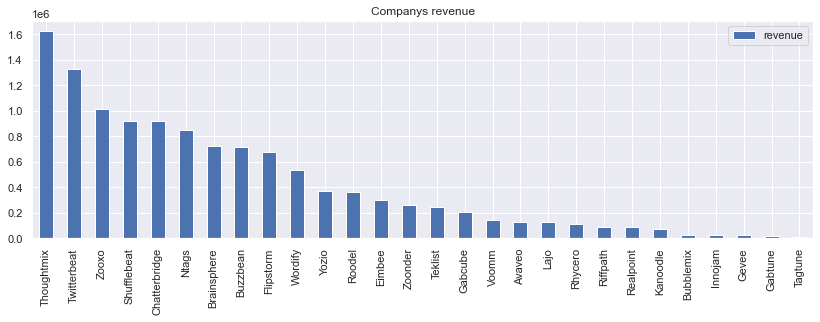

In [43]:
# your code goes here
#!pip install pandasql==0.7.3
import pandas as pd
import pandasql as psql
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

company_rev = psql.sqldf("""
  SELECT company,
         sum(prices_euro) AS revenue
    FROM df_transactions_cleaned
    GROUP BY company
    ORDER BY sum(prices_euro) DESC
""")

company_rev
_ =  company_rev \
              .plot(kind='bar', color=sns.color_palette(), figsize=(14,4),
                    title='Companys revenue')
_ = plt.xticks(np.arange(len(company_rev['company'].index)), 
               company_rev['company'], rotation=90)

### Country by revenue, per year

The revenue of a country in a time period, is its total value of orders in that time period. Compute and visualise all countries by revenue, for years 2016, 2017 and 2018. Your visualisation should have countries on the x-axis and multiple bars (one for each year).

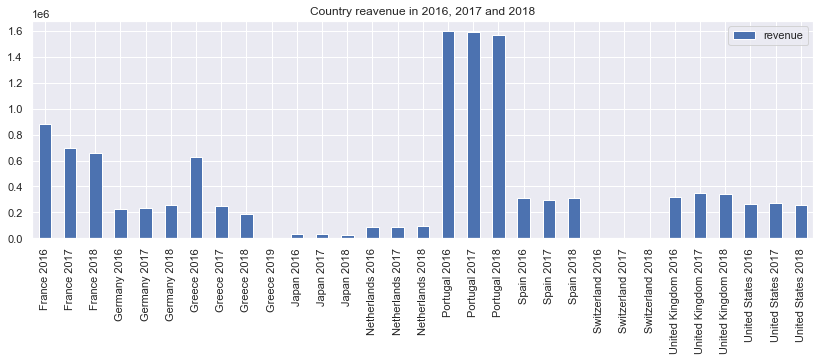

In [44]:
# your code goes here

country_rev = psql.sqldf("""
  SELECT country,
         sum(prices_euro) as revenue,
         STRFTIME('%Y', date) AS year
    FROM df_transactions_cleaned
    GROUP BY country, year
""")


country_rev \
              .plot(kind='bar', color=sns.color_palette(), figsize=(14,4),
                    title='Country reavenue in 2016, 2017 and 2018')

_ = plt.xticks(np.arange(len(country_rev.index)), 
               (country_rev['country']+' '+country_rev['year']), rotation=90)
## create a beautiful barplot

### Orders per quarter, all companies

Compute and visualise the number of orders each company has placed in each quarter. Exclude quarters where the order count is less than 3. As always, be mindful to not produce a cluttered visualisation.

Part of your query should form a variable that converts `date` into `YEAR_QUARTER` format. Dealing with dates is via `STRFTIME` [docs](https://www.sqlite.org/lang_datefunc.html) which doesn't allow quarter extraction. Instead, it allows for extraction of month, which you can case on in order to produce the quarter (Q1, Q2, Q3, Q4).  

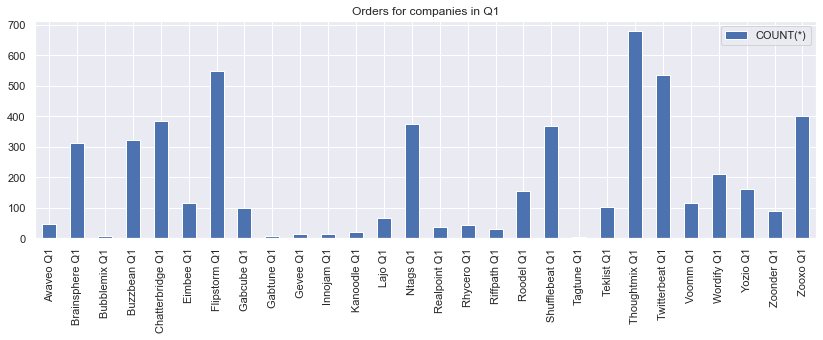

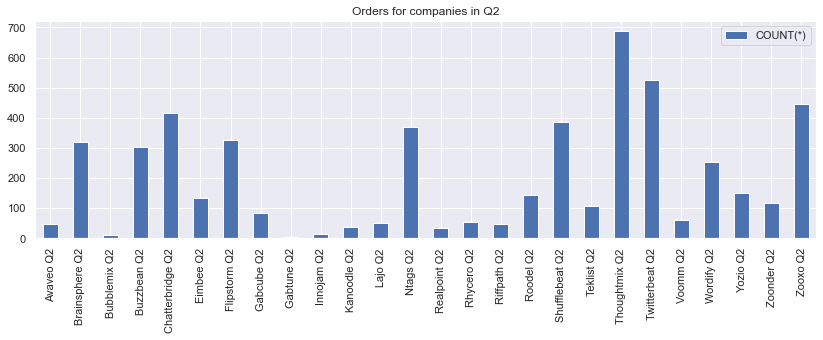

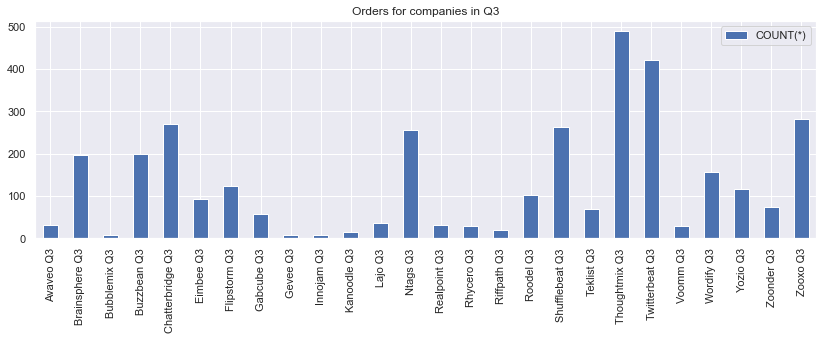

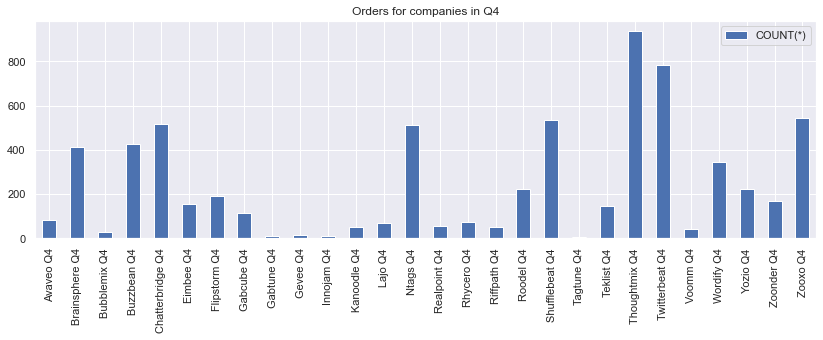

In [45]:
# your code goes here
order_quarter = psql.sqldf("""
  SELECT company,
         COUNT(*),
         CASE
             WHEN STRFTIME('%m', date) <'04' THEN 'Q1'
             WHEN STRFTIME('%m', date) > '03' AND STRFTIME('%m', date) < '07' THEN 'Q2'
             WHEN STRFTIME('%m', date) > '07' AND STRFTIME('%m', date) < '10' THEN 'Q3'
             ELSE 'Q4'
         END YEAR_QUARTER
    FROM df_transactions_cleaned
    GROUP BY company, YEAR_QUARTER
    HAVING COUNT(*) > 3
""")

order_quarter[order_quarter['YEAR_QUARTER']=='Q1'] \
              .plot(kind='bar', color=sns.color_palette(), figsize=(14,4),
                    title='Orders for companies in Q1')

_ = plt.xticks(np.arange(len(order_quarter[order_quarter['YEAR_QUARTER']=='Q1'].index)), 
               (order_quarter[order_quarter['YEAR_QUARTER']=='Q1']['company']+' '+order_quarter[order_quarter['YEAR_QUARTER']=='Q1']['YEAR_QUARTER']), rotation=90)
## create a beautiful barplot

order_quarter[order_quarter['YEAR_QUARTER']=='Q2'] \
              .plot(kind='bar', color=sns.color_palette(), figsize=(14,4),
                    title='Orders for companies in Q2')

_ = plt.xticks(np.arange(len(order_quarter[order_quarter['YEAR_QUARTER']=='Q2'].index)), 
               (order_quarter[order_quarter['YEAR_QUARTER']=='Q2']['company']+' '+order_quarter[order_quarter['YEAR_QUARTER']=='Q2']['YEAR_QUARTER']), rotation=90)
## create a beautiful barplot

order_quarter[order_quarter['YEAR_QUARTER']=='Q3'] \
              .plot(kind='bar', color=sns.color_palette(), figsize=(14,4),
                    title='Orders for companies in Q3')

_ = plt.xticks(np.arange(len(order_quarter[order_quarter['YEAR_QUARTER']=='Q3'].index)), 
               (order_quarter[order_quarter['YEAR_QUARTER']=='Q3']['company']+' '+order_quarter[order_quarter['YEAR_QUARTER']=='Q3']['YEAR_QUARTER']), rotation=90)
## create a beautiful barplot

order_quarter[order_quarter['YEAR_QUARTER']=='Q4'] \
              .plot(kind='bar', color=sns.color_palette(), figsize=(14,4),
                    title='Orders for companies in Q4')

_ = plt.xticks(np.arange(len(order_quarter[order_quarter['YEAR_QUARTER']=='Q4'].index)), 
               (order_quarter[order_quarter['YEAR_QUARTER']=='Q4']['company']+' '+order_quarter[order_quarter['YEAR_QUARTER']=='Q4']['YEAR_QUARTER']), rotation=90)
## create a beautiful barplot

## Part 4: Parts and prices (20 pts)

### Parts demand changes

A different amount of orders are placed on parts each year. The demand of a part is the number of orders placed on it. The demand change of a part is the absolute difference between its average demand in 2016/2017, and its demand in 2018.

Compute and visualise the 15 parts whose demand change has been the largest.

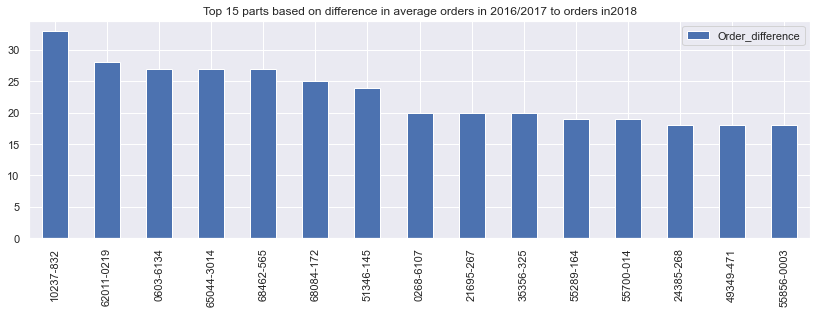

In [46]:
# your code goes here
order_diff = psql.sqldf("""
      WITH first_2 AS (
         SELECT part,
                COUNT(*) AS count
           FROM df_transactions_cleaned
          WHERE STRFTIME('%Y', date) IN ('2016', '2017')
          GROUP BY part
      ), year_18 AS (
         SELECT part,
                COUNT(*) AS count
           FROM df_transactions_cleaned
          WHERE STRFTIME('%Y', date) IN ('2018')
          GROUP BY part
      )
    SELECT part,
           ABS(year_18.count-ROUND(first_2.count/2)) AS Order_difference
      FROM first_2
INNER JOIN year_18 USING (part)
  ORDER BY Order_difference DESC
  LIMIT 15
""")

order_diff\
              .plot(kind='bar', color=sns.color_palette(), figsize=(14,4),
                    title='Top 15 parts based on difference in average orders in 2016/2017 to orders in2018')

_ = plt.xticks(np.arange(len(order_diff.index)),order_diff['part'], rotation=90)



### Popular parts pricing

The most popular parts are those whose demand has increased the most from its 2016/2017 average to 2018. We're interested to find out if popularity is due to a price drop, and also inform us if prices of these parts are properly adjusted.

The demand increase of a part is its 2018 demand minus its 2016/2017 average demand. The price change of a part is its average 2018 price minus its average 2016/2017 price.

Compute the parts whose demand has increased (has positive demand increase) and the change in price for each of these parts. Then visualise this relationship and include in the figure title the correlation (compute via pandas) between these two variables. Conclude which is most likely 1) Parts became more popular from a drop in prices, or 2) The sales department deserved its bonuses.

-0.22


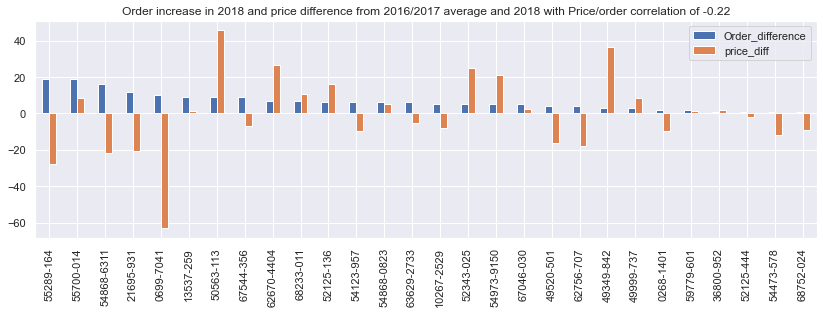

In [47]:
# your code goes here
order_price_diff = psql.sqldf("""
      WITH first_2 AS (
         SELECT part,
                AVG(prices_euro) AS AVGprice,
                COUNT(*) AS count
           FROM df_transactions_cleaned
          WHERE STRFTIME('%Y', date) IN ('2016', '2017')
          GROUP BY part
      ), year_18 AS (
         SELECT part,
                AVG(prices_euro) AS AVGprice,
                COUNT(*) AS count
           FROM df_transactions_cleaned
          WHERE STRFTIME('%Y', date) IN ('2018')
          GROUP BY part
      )
    SELECT part,
            year_18.count-Round(first_2.count/2) AS Order_difference,
            year_18.AVGprice - first_2.AVGprice AS price_diff
      FROM first_2
INNER JOIN year_18 USING (part)
    WHERE Order_difference > 0 
  ORDER BY Order_difference DESC
  
""")

corr = order_price_diff.corr()
print(round(np.array(corr)[0][1],2))
order_price_diff\
              .plot(kind='bar', color=sns.color_palette(), figsize=(14,4),
                    title='Order increase in 2018 and price difference from 2016/2017 average and 2018 with Price/order correlation of'+' '+str(round(np.array(corr)[0][1],2)))

_ = plt.xticks(np.arange(len(order_price_diff.index)),order_price_diff['part'], rotation=90)

From the correlation we see that they are negatively correlated, this indicates that the increase in sales comes more from a decrease in price than from increased effort from the sales department.

But still there is some parts that has increased in sales even though there is an increase in price, and this might be because of the sales department, and also explains why there is a weak negative correlation.